  SOC Code                                Title       aii       aug  aii_p  \
0  11-1011                     Chief Executives  0.000000  0.000000      0   
1  11-1021      General and Operations Managers  0.058824  0.070175      9   
2  11-2011  Advertising and Promotions Managers  0.000000  0.000000      0   
3  11-2021                   Marketing Managers  0.000000  0.000000      0   
4  11-2022                       Sales Managers  0.058824  0.000000      9   

   aug_p  
0      0  
1      7  
2      0  
3      0  
4      0  
Index(['SOC Code', 'Title', 'aii', 'aug', 'aii_p', 'aug_p'], dtype='object')

Cluster centers in original units (aii, aug):
        aii       aug  cluster_id_raw
0  0.037520  0.034586               0
1  0.119194  0.331355               1
2  0.254789  0.077687               2
3  0.324678  0.738213               3

Cluster ID (raw) -> Name mapping:
  0: Low automation, low augmentation
  1: Low automation, high augmentation
  2: High automation, low augmentation


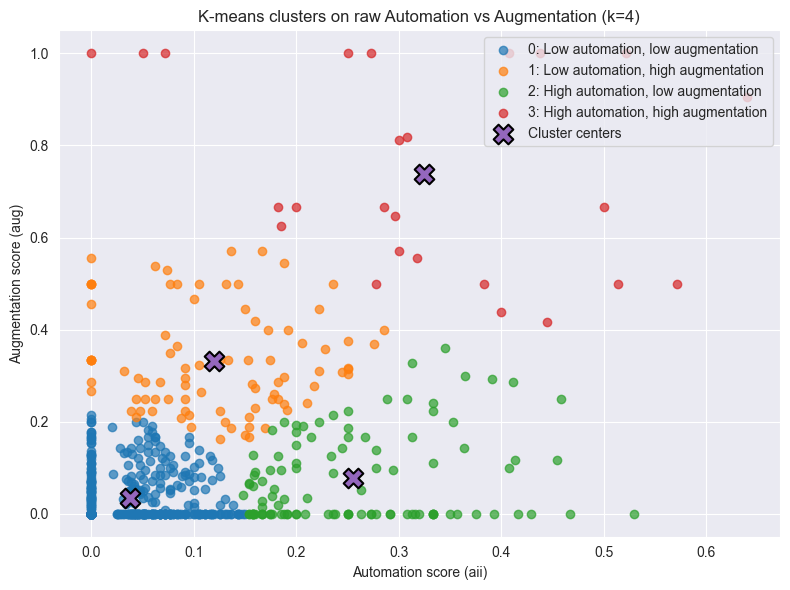

In [7]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt


# load data
df = pd.read_csv("datasets/2022/auto_augment.csv")

print(df.head())
print(df.columns)

# keep only rows with non-missing automation / augmentation scores
df = df.dropna(subset=["aii", "aug"]).copy()

# select raw aii and aug values to test against percentiles
feature_cols = ["aii", "aug"]

X = df[feature_cols].values   # shape: (n_occupations, 2)

# standardize for k means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# run w/ k = 4
k = 4
kmeans = KMeans(
    n_clusters=k,
    random_state=41,
    n_init=20,
    max_iter=1000,
)


kmeans.fit(X_scaled)

# Add cluster IDs to df
df["cluster_id_raw"] = kmeans.labels_   # 0, 1, 2, 3


# Inspect cluster centers in aii/aug units
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

centers_df = pd.DataFrame(
    centers_original,
    columns=feature_cols
)
centers_df["cluster_id_raw"] = range(k)

print("\nCluster centers in original units (aii, aug):")
print(centers_df)


# Assign readable cluster names using  aii/aug
# We'll classify clusters based on their centers, using thresholds
# from the overall median automation and augmentation scores.

auto_thresh = centers_df["aii"].median()
aug_thresh  = centers_df["aug"].median()



cluster_name_map_raw = {}

for _, row in centers_df.iterrows():
    cid = int(row["cluster_id_raw"])
    center_aii = row["aii"]
    center_aug = row["aug"]

    if center_aii >= auto_thresh and center_aug >= aug_thresh:
        name = "High automation, high augmentation"
    elif center_aii >= auto_thresh and center_aug < aug_thresh:
        name = "High automation, low augmentation"
    elif center_aii < auto_thresh and center_aug >= aug_thresh:
        name = "Low automation, high augmentation"
    else:
        name = "Low automation, low augmentation"

    cluster_name_map_raw[cid] = name

print("\nCluster ID (raw) -> Name mapping:")
for cid, name in cluster_name_map_raw.items():
    print(f"  {cid}: {name}")

df["cluster_name_raw"] = df["cluster_id_raw"].map(cluster_name_map_raw)


# visualize results
plt.figure(figsize=(8, 6))

for cid, group in df.groupby("cluster_id_raw"):
    plt.scatter(
        group["aii"],
        group["aug"],
        label=f"{cid}: {cluster_name_map_raw[cid]}",
        alpha=0.7,
    )

# Plot cluster centers
plt.scatter(
    centers_original[:, 0],
    centers_original[:, 1],
    marker="X",
    s=200,
    edgecolor="black",
    linewidth=1.5,
    label="Cluster centers"
)

plt.xlabel("Automation score (aii)")
plt.ylabel("Augmentation score (aug)")
plt.title("K-means clusters on raw Automation vs Augmentation (k=4)")
plt.legend()
plt.tight_layout()
plt.show()

